Data Exploration of given dataset

Parsing train:   0%|          | 0/327 [00:00<?, ?it/s]

Parsing val: 0it [00:00, ?it/s]

Parsing test:   0%|          | 0/13 [00:00<?, ?it/s]

,split,n_images,n_boxes
0,train,327,396
1,val,0,0
2,test,13,19



Klassenverteilung über alle Splits:
  pothole   :   415

Top-5 häufigste Bild­größen (w×h):
  640×640: 340 Bilder


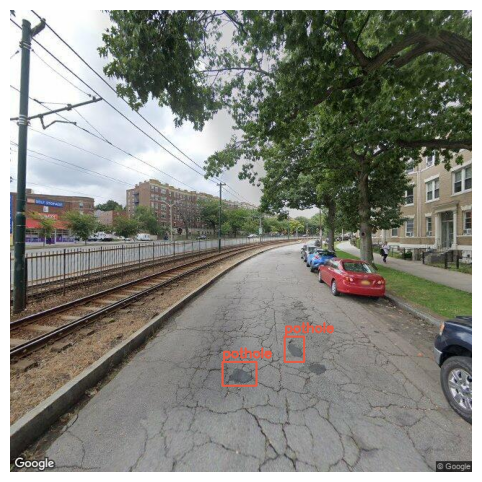

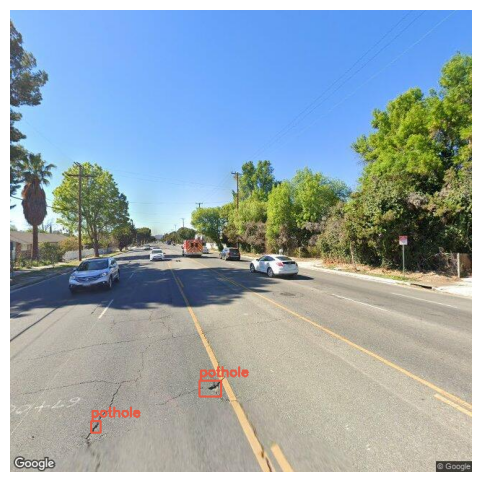

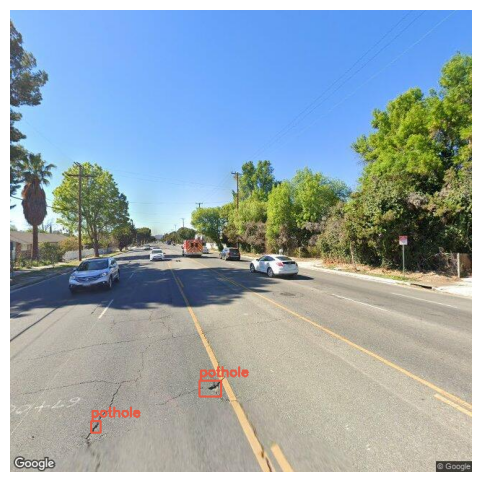

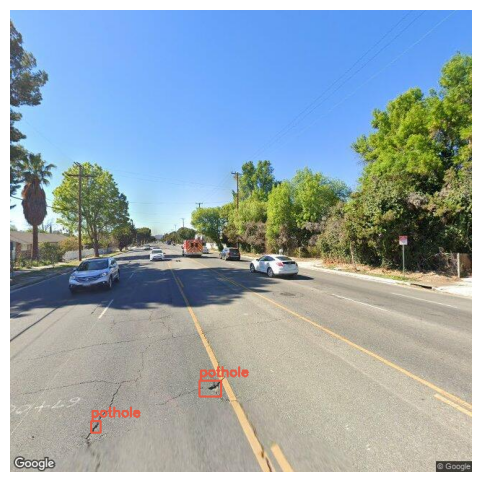

In [9]:
# ============================================================
# 0. Grund­pakete installieren (einmalig ausführen, falls nötig)
# ============================================================
# %pip install pandas matplotlib opencv-python PyYAML tqdm --quiet

# ============================================================
# 1. Imports & Pfade
# ============================================================
import os, glob, yaml, json, random
from pathlib import Path
from collections import Counter, defaultdict

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.rcParams["figure.figsize"] = (8, 6)

# DATA_ROOT = Path("POTHOLEDETECTION")  # → falls du alles in einem Überordner hast
DATA_ROOT = Path(".")                   # Notebook liegt direkt in deinem Projektordner
# Name des Unterdatensatzes (Google-Streetview oder Pretrain, etc.)
DATASET_NAME = "Pothole_Google_Streetview_Image.v4i.yolov8"
SPLITS       = ["train", "val", "test"]  # passen, wenn du später neu splittest

ds_path = DATA_ROOT / DATASET_NAME
assert ds_path.exists(), f"{ds_path} nicht gefunden"

# ============================================================
# 2. Hilfsfunktionen
# ============================================================
def read_yolo_label(label_fp):
    """
    Liest eine YOLO-Label-Datei (.txt) ein und gibt eine Liste von
    (class_id, x_center, y_center, width, height) zurück.
    Werte sind bereits als float normalisiert [0..1].
    """
    with open(label_fp, "r") as f:
        lines = [ln.strip().split() for ln in f if ln.strip()]
    return [(int(li[0]), *map(float, li[1:])) for li in lines]

def boxes_to_pix(bboxes_norm, img_w, img_h):
    """
    Normale YOLO-Koordinaten (cx,cy,w,h in [0..1]) -> Pixel-BBOX (x1,y1,x2,y2)
    """
    boxes = []
    for _, cx, cy, w, h in bboxes_norm:
        cx *= img_w; cy *= img_h
        w  *= img_w; h  *= img_h
        x1 = int(cx - w/2); y1 = int(cy - h/2)
        x2 = int(cx + w/2); y2 = int(cy + h/2)
        boxes.append((x1, y1, x2, y2))
    return boxes

def show_sample(image_fp, label_fp, class_names):
    """
    Zeigt ein Bild mit Bounding-Boxes.
    """
    img  = cv2.cvtColor(cv2.imread(str(image_fp)), cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    bboxes = read_yolo_label(label_fp)
    boxes  = boxes_to_pix(bboxes, w, h)

    # Farben (eine pro Klasse) generieren
    random.seed(42)
    palette = [(random.randint(64,255), random.randint(64,255), random.randint(64,255)) 
               for _ in range(len(class_names))]
    
    for (class_id, *_), (x1,y1,x2,y2) in zip(bboxes, boxes):
        cv2.rectangle(img, (x1,y1), (x2,y2), palette[class_id], 2)
        cv2.putText(img, class_names[class_id], (x1, y1-6),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, palette[class_id], 2)
    plt.imshow(img); plt.axis("off")

# ============================================================
# 3. Daten einlesen & zusammen­fassen
# ============================================================
# Aus data.yaml die Klassen­namen laden (falls vorhanden)
yaml_fp = ds_path / "data.yaml"
if yaml_fp.exists():
    with open(yaml_fp) as f:
        ycfg = yaml.safe_load(f)
    class_names = ycfg["names"] if isinstance(ycfg["names"], (list, tuple)) else list(ycfg["names"].values())
else:
    class_names = ["pothole"]

split_stats = []
box_counter = Counter()
img_dim_counter = Counter()

for split in SPLITS:
    img_dir   = ds_path / split / "images"
    label_dir = ds_path / split / "labels"
    img_files = sorted(glob.glob(str(img_dir/"*.jpg")) + 
                       glob.glob(str(img_dir/"*.png")))
    n_imgs = len(img_files)
    
    # pro Split BBox-Infos sammeln
    n_boxes_split = 0
    for img_fp in tqdm(img_files, desc=f"Parsing {split}", leave=False):
        label_fp = label_dir / (Path(img_fp).stem + ".txt")
        if not label_fp.exists():
            continue                      # unge­label­tes Bild
        labels = read_yolo_label(label_fp)
        n_boxes_split += len(labels)
        # Klassen zählen
        box_counter.update([li[0] for li in labels])
        # Bild-Dimensionen
        h,w = cv2.imread(img_fp).shape[:2]
        img_dim_counter.update([(w,h)])
    
    split_stats.append(dict(
        split   = split,
        n_images= n_imgs,
        n_boxes = n_boxes_split
    ))

df_stats = pd.DataFrame(split_stats)
display(df_stats)

print("\nKlassenverteilung über alle Splits:")
for cid, cnt in box_counter.items():
    print(f"  {class_names[cid]:<10}: {cnt:>5}")

print("\nTop-5 häufigste Bild­größen (w×h):")
for (w,h),cnt in img_dim_counter.most_common(5):
    print(f"  {w}×{h}: {cnt} Bilder")

# ============================================================
# 4. Beispiel­bilder anzeigen
# ============================================================
N_SAMPLES = 4
for _ in range(N_SAMPLES):
    split = random.choice(SPLITS)
    img_dir   = ds_path / split / "images"
    label_dir = ds_path / split / "labels"
    img_fp    = random.choice(glob.glob(str(img_dir/"*")))
    label_fp  = label_dir / (Path(img_fp).stem + ".txt")
    if not label_fp.exists():  # evtl. kein Label → skip
        continue
    show_sample(img_fp, label_fp, class_names)
    plt.show()
